In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import matplotlib.animation

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve, least_squares, minimize
from scipy.stats import qmc 
from scipy.linalg import norm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import argrelmin, argrelmax
from numba import jit
from tabulate import tabulate
from itertools import product
from operator import itemgetter

In [91]:
def svs(sol, param):
    
    """Sources and sinks of each constituant in the coupled NPZV model.
    
    sol: solve_ivp solution object
    param: all parameters needed for calulation
    """
    
    #Parameter definitions (floats)
    V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, \
    μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω = param
    
    L = len(sol.t)
    
    #Defineing state solutions (arrays)
    N_n = sol.y[0] #New nutrients (Nitrate)
    N_r = sol.y[1] #Recycled Nutrients (Ammonium)
    P_U = sol.y[2] #Susceptible Hosts
    P_I = sol.y[3] #Infected Hosts
    Z   = sol.y[4] #Zooplankton
    V_I = sol.y[5] #Internal viruses from host NT recycling and de novo NT synthesis
    V_E = sol.y[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    P = P_U + P_I                                #array
    N = N_n + N_r                                #array
    nutr_lim = N / (K_N + N)                     #array
    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #float
    psi = V_max * nutr_lim * light_lim           #array
    
    ν_i = np.zeros(L)
    scales = [[], [], [], [], []] #scales only apply to living constituents, thus 5 rows
    
    #Defing arrays that require specific logic at each step
    for i in range(L):
        
        if N[i] == 0: N[i] = 1 #avoid divison by 0 when evaluating nutrient ratios
                               #shouldn't affect nutrient limitation terms

        if V_I[i] != 0: ν_i[i] = V_I[i] / ((beta / alpha) * P_I[i] + V_I[i])

        #Defining the scaling factors that continuously reduce the affect of growth
        #as state variables reach ecologically unrealistic densities (e.g. 1e-20)
        thresh = 1e-8  #threshold for when growth damping begins
    
        for j, state in enumerate([P_U[i], P_I[i], Z[i], V_I[i], V_E[i]]):
            
            scale = 1
            if state < thresh: scale = state / thresh 
            scales[j].append(scale)

        #Place holder for recovered_correction terms
            
    P_U_scale, P_I_scale, Z_scale, V_I_scale, V_E_scale = np.array(scales) #arrays
         
    #Infected Phytoplankton
    P_I_svs = {}
    
    P_I_svs["Growth"]    = P_I_scale * (1 - P_U_scale * μ_u) * P_I * psi
    P_I_svs["Adsorp"]    = P_I_scale * (1 - ν_x) * φ * μ_s * P_U * V_E
    P_I_svs["Grazing"]   = P_I * Z_scale * g * Z / K_P
    P_I_svs["Mortality"] = P_I * λ_P
    P_I_svs["NT_recy"]   = P_I * ν_i * μ_V
    P_I_svs["Lysis"]     = P_I * ν_i * δ
    
    P_I_svs["Sources"] = P_I_svs["Growth"] + P_I_svs["Adsorp"]
    P_I_svs["Sinks"]   = P_I_svs["Grazing"] + P_I_svs["Mortality"] + P_I_svs["NT_recy"] + P_I_svs["Lysis"]
    P_I_svs["dP_Idt"]  = P_I_svs["Sources"] - P_I_svs["Sinks"]
    
    #Zooplankton
    Z_svs = {}
    
    Z_svs["Assim"]     = Z * Z_scale * γ_Z * g * (P + V_I) / K_P
    Z_svs["Mortality"] = Z * (λ_Z + λ_Z_hat * Z)
    
    Z_svs["Sources"] = Z_svs["Assim"]
    Z_svs["Sinks"]   = Z_svs["Mortality"]
    Z_svs["dP_Idt"]  = Z_svs["Sources"] - Z_svs["Sinks"]
    
    #Intracellular Viruses 
    V_I_svs = {}
    
    V_I_svs["Growth"]    = V_I_scale * (beta / alpha) * ν_i * (μ_V + (nutr_lim * μ_V_prime)) * P_I
    V_I_svs["Adsorp"]    = V_I_scale * (beta / alpha) * ν_x * φ * μ_s * P_U * V_E
    V_I_svs["Grazing"]   = V_I * Z_scale * g * Z / K_P
    V_I_svs["Lysis"]     = V_I * V_E_scale * ν_i * δ
    V_I_svs["Host Mort"] = V_I * λ_P
    
    V_I_svs["Sources"] = V_I_svs["Growth"] + V_I_svs["Adsorp"]
    V_I_svs["Sinks"]   = V_I_svs["Grazing"] + V_I_svs["Lysis"] + V_I_svs["Host Mort"]
    V_I_svs["dV_Idt"]  = V_I_svs["Sources"] - V_I_svs["Sinks"]

    return P_I_svs, Z_svs, V_I_svs


In [2]:
%store -r test param

In [92]:
P_I_svs, Z_svs, V_I_svs = svs(test, param)

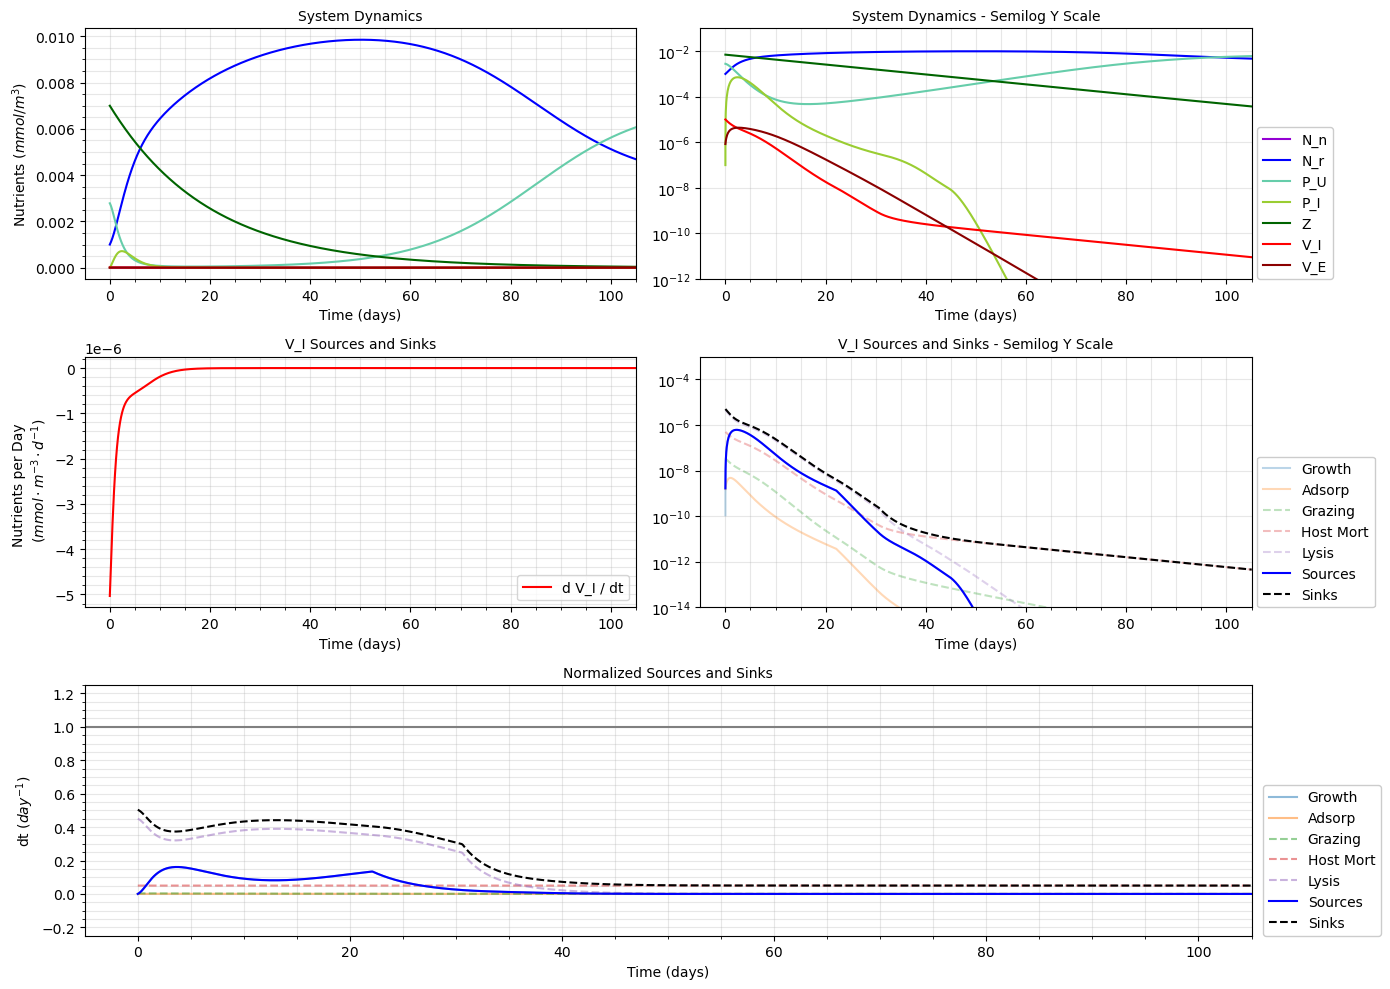

In [102]:
time_span = test.t
P_I = test.y[3]
V_I = test.y[5]

states = [test.y[i] for i in range(7)]

labels = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']
colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]
          
fig = plt.figure(figsize = (14, 10))
ax = fig.subplot_mosaic("""AB;CD;EE""")

#Visualizing Dynamics
for i in range(7): 
    ax["A"].plot(time_span, states[i], color=colors[i], label=labels[i])
    ax["B"].plot(time_span, states[i], color=colors[i], label=labels[i])

ax["A"].set_title('System Dynamics', fontsize=10)
ax["A"].set_ylabel(r'Nutrients ($mmol/m^3$)')

ax["B"].set_title('System Dynamics - Semilog Y Scale', fontsize=10)
ax["B"].set_yscale('log')
ax["B"].set_ylim(1e-12, 1e-1)

### Visualizing P_I sources and sinks
# ax["C"].plot(time_span, P_I_svs["dP_Idt"], color='red', label="d P_I / dt")
# ax["C"].set_title('P_I Sources and Sinks', fontsize=10)
# ax["C"].set_ylabel('Nutrients per Day \n ($mmol \cdot m^{-3} \cdot d^{-1}$)')
# ax["C"].legend()

# for key in ['Growth','Adsorp']:
#     ax["D"].plot(time_span, P_I_svs[key], label=key, alpha=.3)
# for key in ['Grazing','Mortality','NT_recy','Lysis']:
#     ax["D"].plot(time_span, P_I_svs[key], '--', label=key, alpha=.3)

# ax["D"].plot(time_span, P_I_svs["Sources"], color='blue', label="Sources")
# ax["D"].plot(time_span, P_I_svs["Sinks"], '--', color='black', label="Sinks")
# ax["D"].set_title('P_I Sources and Sinks - Semilog Y Scale', fontsize=10)
# ax["D"].set_yscale('log')
# ax["D"].set_ylim(1e-12, 1e-2)

# for key in ['Growth','Adsorp']:
#     ax["E"].plot(time_span, P_I_svs[key] / P_I, label=key, alpha=.5)
# for key in ['Grazing','Mortality','NT_recy','Lysis']:
#     ax["E"].plot(time_span, P_I_svs[key] / P_I, '--', label=key, alpha=.5)

# ax["E"].axline((0, 1), slope=0, color='grey')
# ax["E"].plot(time_span, P_I_svs["Sources"] / P_I, color='blue', label="Sources")
# ax["E"].plot(time_span, P_I_svs["Sinks"] / P_I, '--', color='black', label="Sinks")
# ax["E"].set_title('Normalized Sources and Sinks', fontsize=10)
# ax["E"].set_ylabel('dt ($day^{-1}$)', fontsize=10)
# ax["E"].set_ylim(-.5, 2.5)

### Visualizing V_I sources and sinks
ax["C"].plot(time_span, V_I_svs["dV_Idt"], color='red', label="d V_I / dt")
ax["C"].set_title('V_I Sources and Sinks', fontsize=10)
ax["C"].set_ylabel('Nutrients per Day \n ($mmol \cdot m^{-3} \cdot d^{-1}$)')
ax["C"].legend()

for key in ['Growth','Adsorp']:
    ax["D"].plot(time_span, V_I_svs[key], label=key, alpha=.3)
for key in ['Grazing','Host Mort','Lysis']:
    ax["D"].plot(time_span, V_I_svs[key], '--', label=key, alpha=.3)

ax["D"].plot(time_span, V_I_svs["Sources"], color='blue', label="Sources")
ax["D"].plot(time_span, V_I_svs["Sinks"], '--', color='black', label="Sinks")
ax["D"].set_title('V_I Sources and Sinks - Semilog Y Scale', fontsize=10)
ax["D"].set_yscale('log')
ax["D"].set_ylim(1e-14, 1e-3)

for key in ['Growth','Adsorp']:
    ax["E"].plot(time_span, V_I_svs[key] / V_I, label=key, alpha=.5)
for key in ['Grazing','Host Mort','Lysis']:
    ax["E"].plot(time_span, V_I_svs[key] / V_I, '--', label=key, alpha=.5)

ax["E"].axline((0, 1), slope=0, color='grey')
ax["E"].plot(time_span, V_I_svs["Sources"] / V_I, color='blue', label="Sources")
ax["E"].plot(time_span, V_I_svs["Sinks"] / V_I, '--', color='black', label="Sinks")
ax["E"].set_title('Normalized Sources and Sinks', fontsize=10)
ax["E"].set_ylabel('dt ($day^{-1}$)', fontsize=10)
ax["E"].set_ylim(-.25, 1.25)

for plot in ax:
    ax[plot].set_xlabel('Time (days)')
    ax[plot].set_xlim(-5, 105)

    ax[plot].grid(which='both', alpha=.3)
    ax[plot].minorticks_on()
    
ax["B"].legend(loc=(1.01, 0), framealpha=1)
ax["D"].legend(loc=(1.01, 0), framealpha=1)
ax["E"].legend(loc=(1.01, 0), framealpha=1)
plt.tight_layout()
plt.show()

## Slope Test Examples

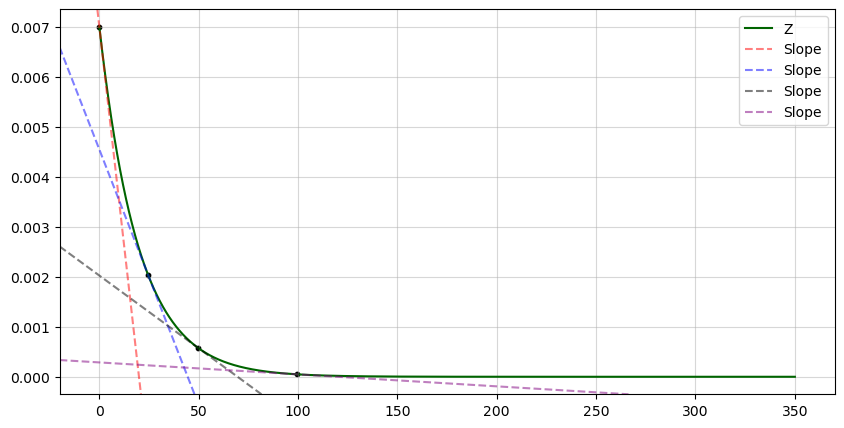

In [52]:
#Z slope tests example
t = test.t
Z = test.y[4]

plt.figure(figsize=(10, 5))
plt.plot(t, Z, color='darkgreen', label='Z')

index = [0, 250, 500, 1000]
colors = ['red', 'blue', 'black', 'purple']

for i in range(len(index)):
    plt.scatter(t[index[i]], Z[index[i]], color='black', s=10)
    plt.axline((t[index[i]], Z[index[i]]), 
               slope=sum(Z_svs.values())[index[i]], 
               color=colors[i], linestyle='--', label='Slope', alpha=.5)

plt.xlim(-20, 370)
plt.legend()
plt.grid(alpha=.5)
plt.show()

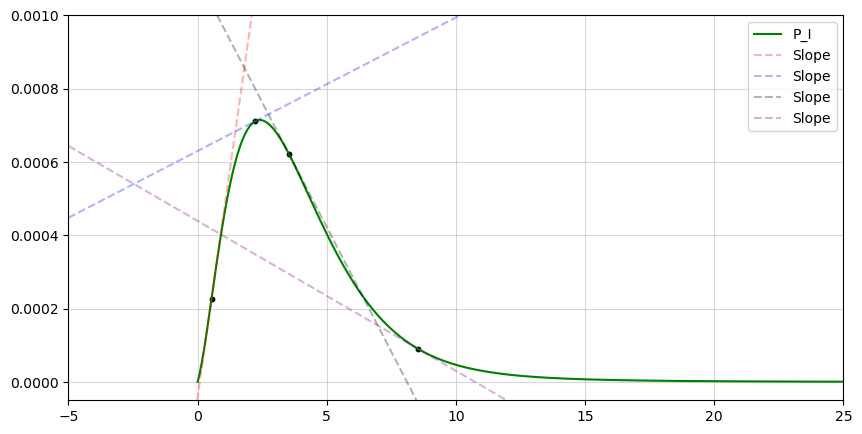

In [62]:
#P_I Slope tests example
t = test.t
P_I = test.y[3]

plt.figure(figsize=(10, 5))
plt.plot(t, P_I, color='green', label='P_I')

index = [10, 27, 40, 90]
colors = ['red', 'blue', 'black', 'purple']

slopes = sum(P_I_svs.values())

for i in range(len(index)):
    plt.scatter(t[index[i]], P_I[index[i]], color='black', s=10)
    plt.axline((t[index[i]], P_I[index[i]]), slope=slopes[index[i]], 
               linestyle='--', color=colors[i], label='Slope', alpha=.3)

plt.xlim(-5, 25)
plt.ylim(-5e-5, 1e-3)

plt.legend()
plt.grid(alpha=.5)
plt.show()